### Osnovna ponavljajoča nevronaska mreža (_ang. RNN-Recurrent Neural Network_)
Za začetek učenja ponavljajočih nevronskih mrež poizkušajmo slediti in implementirati osnovni RNN po [tem tutorialu](http://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html).  
V kategorijo ponavljajočih nevronskih mrež spadajo predvsem takšne mreže, ki s pomočjo ponavljajočega izvajanja dela mreže ali ciklične povezanosti poizkušajo razumeti zaporedne lastnosti nabora podatkov. Ideja temelji na n-kratni ponovitvi RNN-celice, ki je v jedru nevronske mreže. RNN-ji so najbolj uporabni za časovno odvisne nabore podatkov, katerih osnovna lastnost je, da vsebujejo nize podatkov. RNN-celice so sestavljene tako, da te nize podatkov sprocesirajo po delih, vsak del v svoji ponovitvi. Med seboj so povezane tako, da se izhodni podatki ene ponovitve celice dodajo vhodnim podatkom naslednje ponovitve in s tem pridobimo možnost, da pomen podatkov prvega dela niza vpliva na pomen podatkov v naslednjem delu niza itn.  
Ta osnovna ideja ponavljajočih nevronskih mrež je v zgornjem tutorialu lepo opisana in prikazana na sintetičnem naboru podatkov. Spodnja koda pa je prvi del kode, ki je nastala ob sledenju zgornji povezavi.

In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Global config variables
num_steps = 10 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

In [3]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [4]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
Inputs
"""

rnn_inputs = tf.one_hot(x, num_classes)

"""
RNN
"""

cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

"""
Predictions, loss, training step
"""

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = tf.reshape(
            tf.matmul(tf.reshape(rnn_outputs, [-1, state_size]), W) + b,
            [batch_size, num_steps, num_classes])
predictions = tf.nn.softmax(logits)

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [5]:
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, input_x, rnn_out, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              rnn_inputs,
                              rnn_outputs,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
                    print(input_x[0],'\n', rnn_out[0])

    return training_losses


EPOCH 0
Average loss at step 100 for last 250 steps: 0.622288075089
[[ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]] 
 [[ 0.4146623  -0.54323041  0.71038729  0.75951642]
 [ 0.56690001 -0.08678813 -0.05555882 -0.8841241 ]
 [ 0.28110269  0.11736859 -0.31548217  0.85789412]
 [ 0.41539589 -0.18349363  0.62354994  0.46098316]
 [ 0.51565337 -0.32934466  0.07751327 -0.7773484 ]
 [ 0.29000697  0.35846323 -0.42353064  0.76356369]
 [ 0.38770413 -0.38119087  0.70141125  0.62229043]
 [ 0.68884724  0.55969411  0.17840759 -0.3843075 ]
 [ 0.62217927 -0.34705052  0.34672886  0.78644061]
 [ 0.73980719  0.24058397  0.23670521 -0.0478593 ]]
Average loss at step 200 for last 250 steps: 0.528475174308
[[ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]] 
 [[ 0.59386432 -0.72460991 -0.04805132 -0.0585435 ]
 [ 0.37114593  0.25346377 -0.59148115  0.54953313]
 [ 0.14125651 -0.44088778  0.536

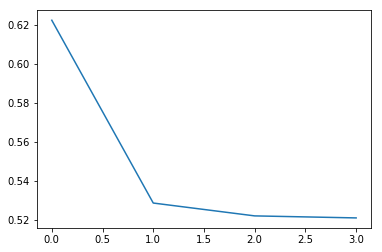

In [6]:
training_losses = train_network(1,num_steps)
plt.plot(training_losses)